In [1]:
from lib import *

Validator = validation.Validator
hyperopt_objective = validation.hyperopt_objective

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

import scipy

from tqdm._tqdm_notebook import tqdm_notebook
from tqdm._tqdm_notebook import tqdm
tqdm_notebook.pandas()

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

/tmp/ipykernel_102883/1809128378.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [3]:
import warnings

from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
# warnings.filterwarnings('ignore', category=LinAlgWarning)

In [4]:
FETCH_BACKUP = True

## Load train, test sets, idx's

In [5]:
import pickle

def load_pickle(dataset, name):
    dataset.to_pickle(name + '.pkl')

def from_pickle(path):
    with open(path, 'rb') as reader:
        return pickle.load(reader)

In [6]:
dataset_paths = [
    '/home/denissimo/Repo/fs_project/datasets/sample_submission.csv',
    '/home/denissimo/Repo/fs_project/datasets/test.csv',
]

df_provider = DatasetProvider()
df_provider.file_list = dataset_paths
datasets = df_provider.get_dataset()

In [7]:
task_df = {}

task_df['test'] = from_pickle('../tmp/task_df_test.pkl')
task_df['train'] = from_pickle('../tmp/task_df_train.pkl')
task_df['idx'] = from_pickle('../tmp/idx.pkl')

valid_idx = from_pickle('../tmp/non_pike.pkl')

In [8]:
MAP = datasets['test.csv'].merge(
    task_df['idx'][['shop_id', 'item_id', 'id']],
    on=['shop_id', 'item_id'],
    how='left'
)

In [9]:
baseline_train = from_pickle('../tmp/baseline_model_training_set.pkl')
validation_set = from_pickle('../tmp/baseline_model_tuning_set.pkl')
test_set = from_pickle('../tmp/baseline_model_validation_set.pkl')
submition_set = from_pickle('../tmp/baseline_submission_set.pkl')

In [10]:
for key in baseline_train:
    if not key in ['target', 'lags']:
        baseline_train[key].columns = [f'{key}_{agg_type}' for agg_type in baseline_train[key].columns.values]
        validation_set[key].columns = [f'{key}_{agg_type}' for agg_type in validation_set[key].columns.values]
        submition_set[key].columns = [f'{key}_{agg_type}' for agg_type in submition_set[key].columns.values]
        test_set[key].columns = [f'{key}_{agg_type}' for agg_type in test_set[key].columns.values]

In [11]:
spike_full_train = pd.concat(baseline_train.values(), axis=1, join='inner')
spike_full_test = pd.concat(validation_set.values(), axis=1, join='inner')
spike_full_eval = pd.concat(test_set.values(), axis=1, join='inner')
spike_full_submission = pd.concat(submition_set.values(), axis=1, join='inner')

In [12]:
full_train = spike_full_train[spike_full_train.index.isin(valid_idx)]
full_test = spike_full_test[spike_full_test.index.isin(valid_idx)]
full_eval = spike_full_eval[spike_full_eval.index.isin(valid_idx)]

In [13]:
submition_set = spike_full_submission[spike_full_submission.index.isin(valid_idx)]

In [14]:
def dyn_agg(months):
    return {f'dynamic_aggregation_{k}_win_{months}':f'dynamic_aggregation_{k}_all' for k in ['mean', 'std', 'min', 'max']}


train_x = full_train.drop(['target'], axis=1).rename(dyn_agg(31), axis=1)
train_y = full_train.loc[:, ['target']]

test_x = full_test.drop(['target'], axis=1).rename(dyn_agg(32), axis=1)
test_y = full_test.loc[:, ['target']]

eval_x = full_eval.drop(['target'], axis=1).rename(dyn_agg(33), axis=1)
eval_y = full_eval.loc[:, ['target']]

submition_set = submition_set.rename(dyn_agg(33), axis=1)

## Linear model preprocessing

In [15]:
def make_scaled(df_origin):
    def standartize(dataset):
        scaler = StandardScaler()
        try:
            return scaler.fit_transform(dataset.to_numpy())
        except:
            return scaler.fit_transform(dataset)

    df = pd.DataFrame(
        data=standartize(df_origin), 
        index=df_origin.index, 
        columns=df_origin.columns
    )
    return df

In [16]:
train_x = make_scaled(train_x)
test_x = make_scaled(test_x)
eval_x = make_scaled(eval_x)

## Feature evaluation

In [17]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

if not FETCH_BACKUP:
    evaluation_forest = RandomForestRegressor(n_jobs=-1, max_depth=400)
    evaluation_forest.fit(train_x, train_y)
    with open('../tmp/baseline_rfr.pkl', 'wb+') as writer:
        pickle.dump(evaluation_forest, writer)
else:
    evaluation_forest = from_pickle('../tmp/baseline_rfr.pkl')

### Primary feature selection

In [18]:
from sklearn.inspection import permutation_importance

if not FETCH_BACKUP:
    perm_importance = permutation_importance(evaluation_forest, train_x, train_y)
    with open('tmp/baseline_importance.pkl', 'wb+') as writer:
        pickle.dump(perm_importance, writer)
else:
    perm_importance = from_pickle('../tmp/baseline_importance.pkl')
    boruta_selected = from_pickle('../tmp/boruta.pkl')

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Explore permutation feature importance

In [19]:
select = pd.DataFrame({'column_name': train_x.columns, 'importance': (boruta_selected.ranking_)}).set_index('column_name').sort_values('importance', ascending=True)
select['importance'] = 90 - select['importance']

<AxesSubplot:xlabel='importance', ylabel='column_name'>

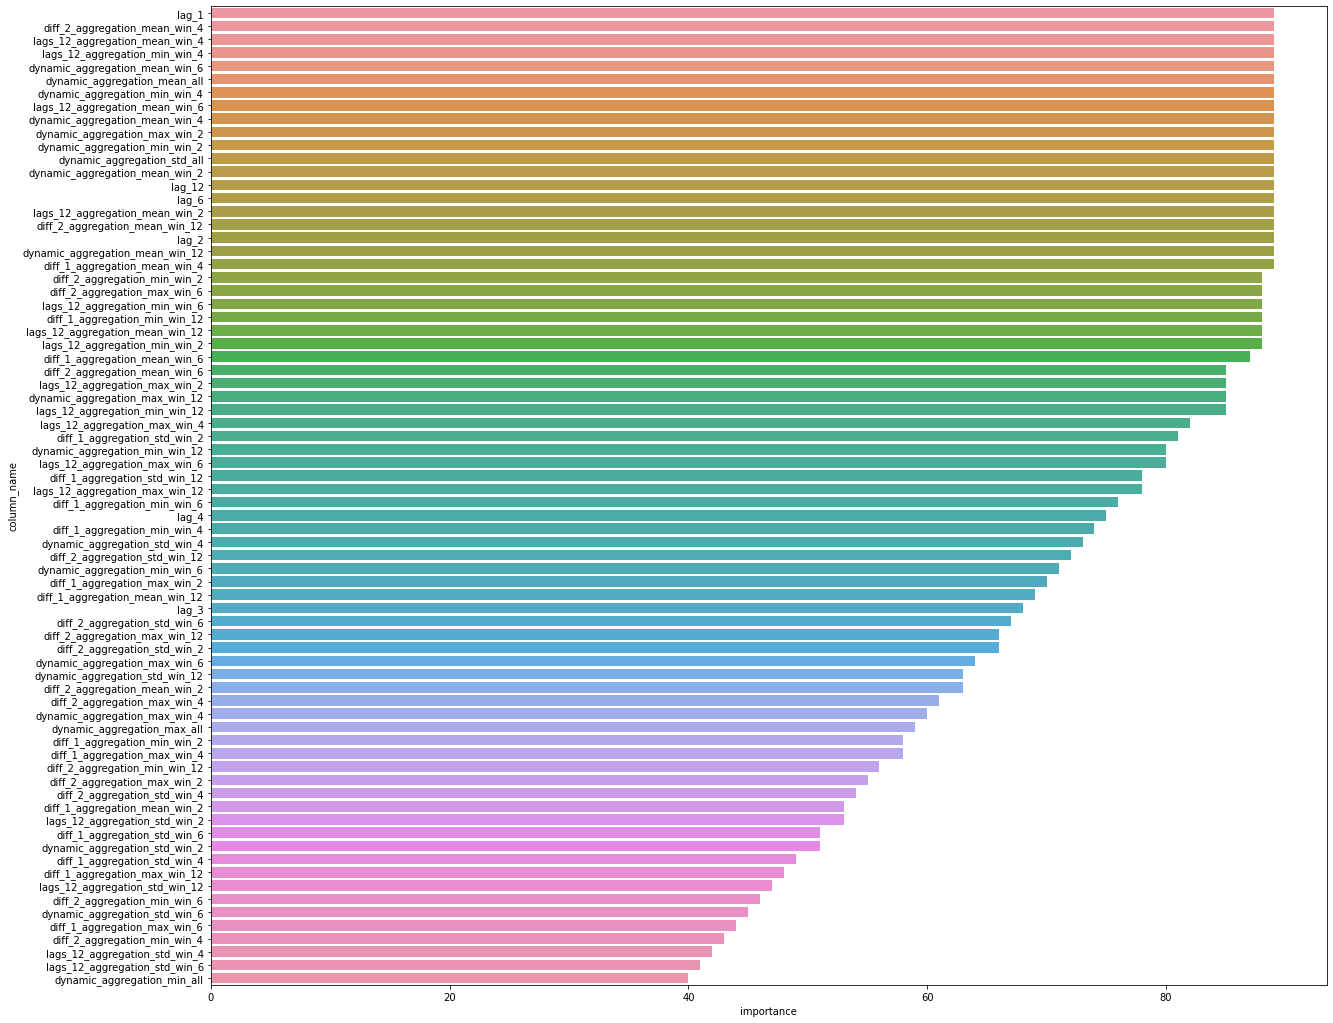

In [20]:
_, axs = plt.subplots(1, 1, figsize=(20, 18))

sns.barplot(data=select.reset_index(), x='importance', y='column_name', ax=axs)

In [21]:
train_x = train_x.loc[:,select[select.importance >= 87].index].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
test_x = test_x.loc[:,select[select.importance >= 87].index].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
eval_x = eval_x.loc[:,select[select.importance >= 87].index].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
submition_set = submition_set.loc[:,select[select.importance >= 87].index].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')

## Hyperparam tuning

In [22]:
fs_dataset_cv = validation.fs_dataset_cv

data,  _ = fs_dataset_cv(train_x, train_y, test_x, test_y)

from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

errors = {}
rs_hpo = {}
advanced_hpo = {}
trials = {}
vis = {}

## Basic models

### We gonna check 3 models (ElasticNet, Random Forest, XGBoost) 

## 1) Ridge regression

1. Random search tuning

In [23]:
from scipy.stats import loguniform

test_fold = [-1 for i in range(len(train_x))] + [0 for i in range(len(test_x))]

searching_params = {
    'alpha': loguniform(1e-10, 1e10)
}

rs_hpo['ridge'] = RandomizedSearchCV(estimator=Ridge(), param_distributions=searching_params, cv=PredefinedSplit(test_fold), n_jobs=-1, n_iter=100, scoring='neg_root_mean_squared_error', return_train_score=True)
rs_hpo['ridge'].fit(*data)
rs_hpo['ridge'].best_params_

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.73799e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.88111e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.02101e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.11698e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/linear_m

{'alpha': 3.403982373474112e-09}

## Random search HPO visualization

<AxesSubplot:xlabel='param_alpha', ylabel='loss'>

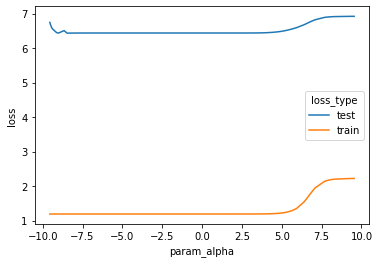

In [24]:
vis['ridge'] = pd.DataFrame({
    'test': rs_hpo['ridge'].cv_results_['split0_test_score'],
    'train': rs_hpo['ridge'].cv_results_['split0_train_score'],
    'param_alpha': rs_hpo['ridge'].cv_results_['param_alpha']}).set_index('param_alpha').stack().reset_index().rename({
    0: 'loss',
    'level_1': 'loss_type'
}, axis=1)
vis['ridge']['loss'] = abs(vis['ridge']['loss'])
vis['ridge']['param_alpha'] = np.log10(vis['ridge']['param_alpha'])
sns.lineplot(data=vis['ridge'], x='param_alpha', y='loss', hue='loss_type')

In [25]:
# define a search space
from hyperopt import hp
from hyperopt import fmin, tpe, Trials

searching_space = {
    'alpha': hp.loguniform('alpha', 0, 25)
}

trials['ridge'] = Trials()
ridge_obj = hyperopt_objective(
    Ridge,
    (train_x, train_y),
    (test_x, test_y)
)

# ridge_obj({'alpha': 1e-7})

# minimize the objective over the space
advanced_hpo['ridge'] = trials['ridge'].fmin(ridge_obj, searching_space, algo=tpe.suggest, max_evals=100)
advanced_hpo['ridge']

{'alpha': 1.0116799309104418}

In [50]:
lin_validator = Validator(Ridge, alpha=3.403982373474112e-09)

lin_validator.fit(test_x, test_y)
errors['ridge'] = lin_validator.validate(eval_x, eval_y)
errors['ridge'][0]

with open('../tmp/ridge_error.pkl', 'wb+') as writer:
        pickle.dump(errors['ridge'], writer)


np.sqrt(errors['ridge'][0])

4.9238142580989335

4. XGBoost

In [27]:
from xgboost import XGBRegressor

In [28]:
searching_space = {
    'n_estimators': hp.choice('n_estimators', np.arange(1, 200, dtype=int)),
    'learning_rate': hp.quniform('eta', 0.1, 1, 0.05),
    'max_depth':  hp.choice('max_depth', np.arange(1, 15, dtype=int)),
    'reg_alpha': hp.qloguniform('reg_alpha', -20, 20, 1),
    'reg_lambda': hp.qloguniform('reg_lambda', -20, 20, 1),
}

trials['xgbr'] = Trials()
xgb_obj = hyperopt_objective(
    XGBRegressor,
    (train_x, train_y),
    (test_x, test_y)
)

advanced_hpo['xgbr'] = trials['xgbr'].fmin(xgb_obj, searching_space, algo=tpe.suggest, max_evals=100, verbose=2)
advanced_hpo['xgbr']

100%|██████████| 100/100 [13:48<00:00,  8.28s/trial, best loss: 6.3404823744213274]


{'eta': 0.55,
 'max_depth': 2,
 'n_estimators': 144,
 'reg_alpha': 0.0,
 'reg_lambda': 3.0}

Strange, it's like Ada Boost

In [29]:
vis['xgbr'] = pd.DataFrame({
    'test': [el['loss'] for el in trials['xgbr'].results],
    'train': [el['other_stuff']['train_rmse'] for el in trials['xgbr'].results],
    'learning_rate': [el['other_stuff']['kwargs']['learning_rate'] for el in trials['xgbr'].results],
    'n_estimators': [el['other_stuff']['kwargs']['n_estimators'] for el in trials['xgbr'].results],
    'alpha': [el['other_stuff']['kwargs']['reg_alpha'] for el in trials['xgbr'].results],
    'lambda': [el['other_stuff']['kwargs']['reg_lambda'] for el in trials['xgbr'].results],
    'max_depth': [el['other_stuff']['kwargs']['max_depth'] for el in trials['xgbr'].results],
})

min_hyp = vis['xgbr'].iloc[vis['xgbr'].test.idxmin()]
vis['xgbr'] = vis['xgbr'].set_index(['learning_rate', 'n_estimators', 'alpha', 'lambda', 'max_depth']).stack().reset_index().rename({
    0: 'loss',
    'level_5': 'loss_type'
}, axis=1)
vis['xgbr']['loss'] = abs(vis['xgbr']['loss'])
vis['xgbr']['alpha'] = np.log10(1 + vis['xgbr']['alpha'])
vis['xgbr']['lambda'] = np.log10(1 + vis['xgbr']['lambda'])
vis['xgbr']

,learning_rate,n_estimators,alpha,lambda,max_depth,loss_type,loss
0,0.70,9,0.000000,7.815382,7,test,6.927296
1,0.70,9,0.000000,7.815382,7,train,2.234504
2,0.15,97,5.162729,2.204120,8,test,6.927712
3,0.15,97,5.162729,2.204120,8,train,2.235710
4,0.30,48,6.597473,7.064412,9,test,6.927712
...,...,...,...,...,...,...,...
195,0.70,49,0.000000,2.155336,1,train,1.286467
196,0.40,167,0.000000,0.000000,3,test,6.353363
197,0.40,167,0.000000,0.000000,3,train,0.711933
198,0.35,31,0.000000,0.000000,3,test,6.410207


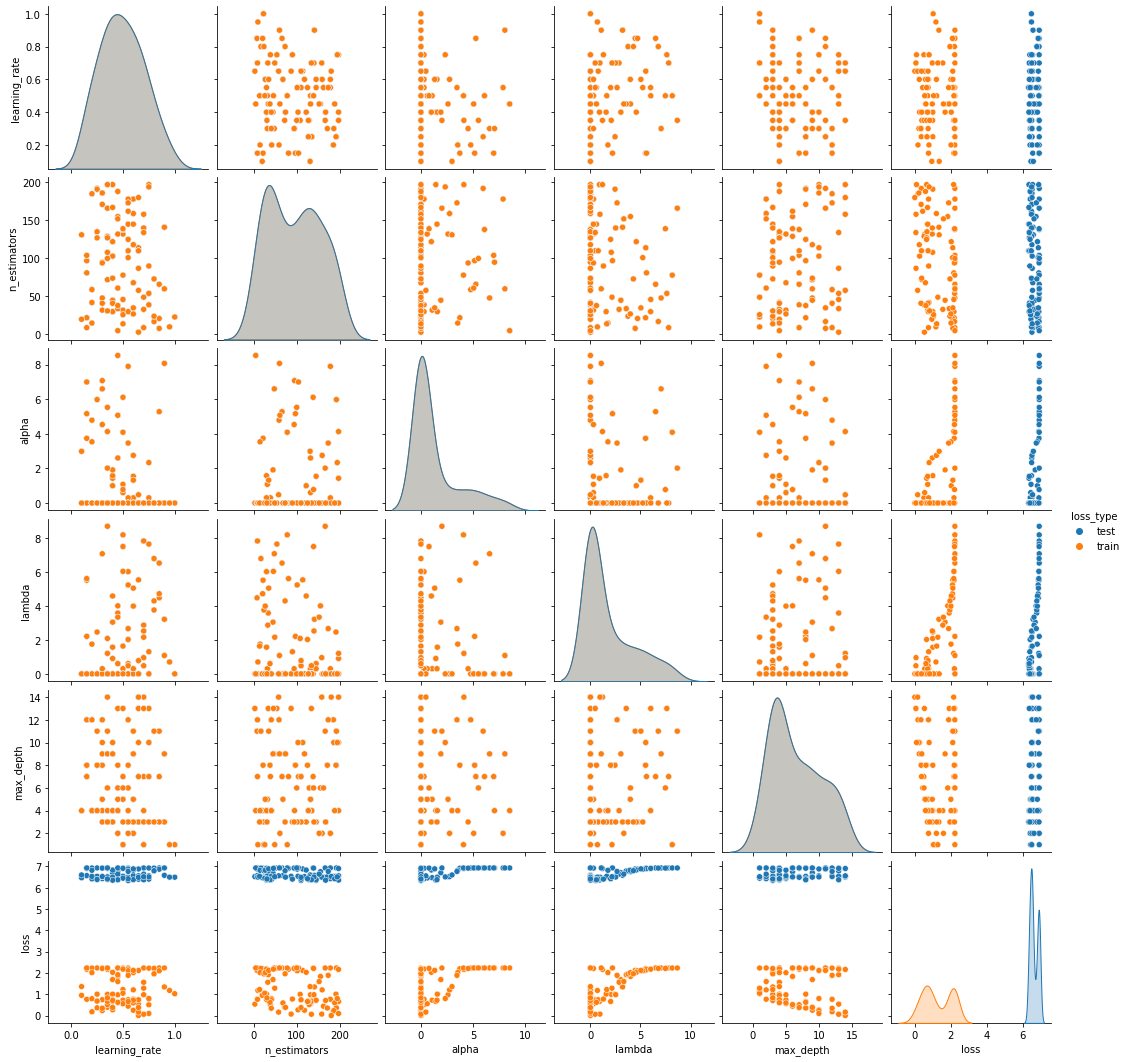

In [30]:
sns.pairplot(data=vis['xgbr'], hue='loss_type')

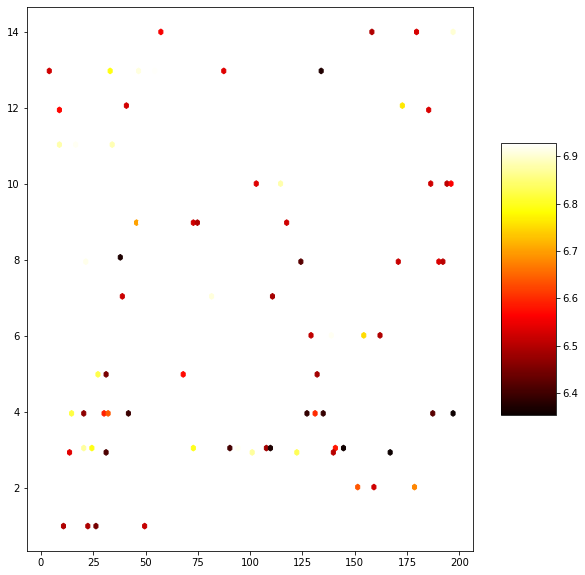

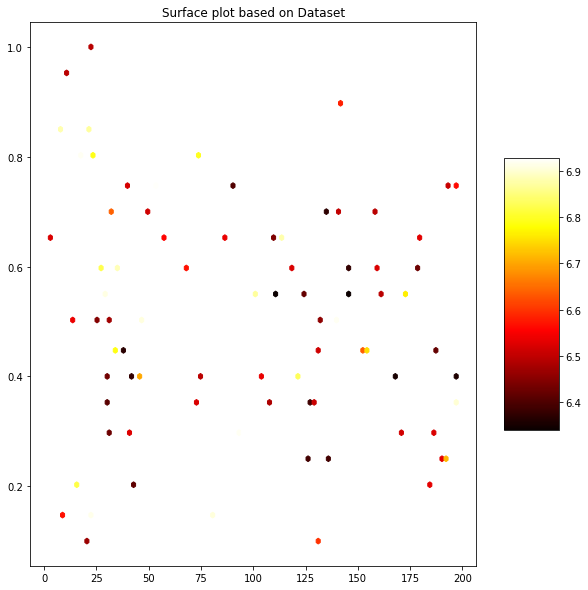

In [31]:
valid_vis = vis['xgbr'][vis['xgbr'].loss_type == 'test']

my_cmap = plt.get_cmap('hot')


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
surf = ax.hexbin(valid_vis['n_estimators'], valid_vis['max_depth'], valid_vis['loss'], cmap=my_cmap)

fig.colorbar( surf, shrink=0.5, aspect=5)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
surf = ax.hexbin(valid_vis['n_estimators'], valid_vis['learning_rate'], valid_vis['loss'], cmap=my_cmap)

fig.colorbar( surf, shrink=0.5, aspect=5)


ax.set_title('Surface plot based on Dataset')

plt.show()

In [32]:
min_kwrgs = min_hyp.drop(['test', 'train']).to_dict()
min_kwrgs['n_estimators'] = int(min_kwrgs['n_estimators'])
min_kwrgs['max_depth'] = int(min_kwrgs['max_depth'])
min_kwrgs

{'learning_rate': 0.55,
 'n_estimators': 145,
 'alpha': 0.0,
 'lambda': 3.0,
 'max_depth': 3}

In [33]:
xgb_validator = Validator(XGBRegressor, **min_kwrgs)

xgb_validator.fit(test_x, test_y)
errors['xgb'] = xgb_validator.validate(eval_x, eval_y)

with open('../tmp/xgb_error.pkl', 'wb+') as writer:
        pickle.dump(errors['xgb'], writer)
np.sqrt(errors['xgb'][0])

5.826132769193451

As we see we can easily overtune our model, so u're welcome to 'residual analysis'

# New submission

In [34]:
submition_set

,lag_1,diff_2_aggregation_mean_win_4,lags_12_aggregation_mean_win_4,lags_12_aggregation_min_win_4,dynamic_aggregation_mean_win_6,dynamic_aggregation_mean_all,dynamic_aggregation_min_win_4,lags_12_aggregation_mean_win_6,dynamic_aggregation_mean_win_4,dynamic_aggregation_max_win_2,...,diff_1_aggregation_mean_win_4,diff_2_aggregation_min_win_2,diff_2_aggregation_max_win_6,lags_12_aggregation_min_win_6,diff_1_aggregation_min_win_12,lags_12_aggregation_mean_win_12,lags_12_aggregation_min_win_2,diff_1_aggregation_mean_win_6,shop_id,item_id
id,,,,,,,,,,,,,,,,,,,,,
1502,0.0,0.00,0.00,0.0,0.000000,0.121212,0.0,0.166667,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,2,30
1503,0.0,0.00,1.00,0.0,0.166667,0.606061,0.0,0.666667,0.25,0.0,...,0.00,0.0,1.0,0.0,-1.0,0.333333,1.0,0.000000,3,30
1504,0.0,0.00,0.00,0.0,0.000000,0.333333,0.0,0.000000,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,4,30
1505,0.0,0.00,0.25,0.0,0.166667,0.575758,0.0,0.166667,0.25,0.0,...,0.00,-2.0,1.0,0.0,-1.0,0.333333,0.0,0.000000,5,30
1506,0.0,-0.25,0.25,0.0,0.166667,1.545455,0.0,0.333333,0.25,1.0,...,0.00,-2.0,1.0,0.0,-1.0,0.333333,0.0,0.000000,6,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329774,0.0,0.00,0.00,0.0,0.000000,1.151515,0.0,0.000000,0.00,0.0,...,0.00,0.0,0.0,0.0,-4.0,0.000000,0.0,0.000000,54,22092
1329776,2.0,0.50,1.50,0.0,0.333333,0.727273,0.0,1.000000,0.50,2.0,...,0.50,0.0,2.0,0.0,-3.0,0.500000,2.0,0.333333,56,22092
1329777,0.0,-0.50,0.00,0.0,1.000000,3.575758,0.0,0.000000,1.00,2.0,...,-0.25,-3.0,2.0,0.0,-11.0,1.500000,0.0,0.000000,57,22092


In [38]:
subm_regressor = Ridge(alpha=1.0117)

subm_regressor.fit(eval_x, eval_y)
predict = subm_regressor.predict(submition_set)

In [51]:
submit = submition_set.reset_index()[['id']]
submit['target'] = predict
# submit.loc[abs(submit.target) < 0.25, 'target'] = 0
submit = submit.merge(MAP, on='id', how='right').drop(['shop_id', 'item_id'], axis=1).rename({'target':'item_cnt_month'}, axis=1).drop('id', axis=1).fillna(0).set_index('ID')

submit.to_csv('../tmp/submit_2.csv')

In [52]:
submit

,item_cnt_month
ID,
0,1.091787
1,0.000000
2,1.128211
3,0.000000
4,0.000000
...,...
214195,0.191914
214196,0.000000
214197,0.137230
